In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import lightgbm as lgb
from copy import deepcopy
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('../Base_Umbilo.csv', sep=';',decimal=',')
df.set_index('Dia', inplace=True)

df

Q_entrada  NH_entrada  TSS_entrada  DQO_entrada  DBO_entrada  \
Dia                                                                          
0.000000    4719.000000   21.000000   271.000000   391.000000   198.575000   
0.041667    4766.833372   21.041667   271.208333   391.375000   198.761875   
0.083333    4814.666743   21.083333   271.416667   391.750001   198.948750   
0.125000    4862.500115   21.125000   271.625000   392.125001   199.135625   
0.166667    4910.333486   21.166667   271.833334   392.500001   199.322501   
...                 ...         ...          ...          ...          ...   
364.833625  2891.467657   17.166375   173.332750   246.831874   126.034431   
364.875292  2767.884225   17.124708   173.249416   246.623540   125.953181   
364.916959  2644.300792   17.083041   173.166083   246.415207   125.871931   
364.958625  2520.717360   17.041375   173.082749   246.206873   125.790681   
365.000000  2334.275029   16.978515   172.957030   245.892574   125.668104   

            TN_entrada  TKN_entrada  TP_entrada  PO_entrada      Q_saida  \
Dia                                                                        
0.000000     34.060000    34.060000    8.020000         4.6  6135.066621   
0.041667     34.114167    34.114167    8.023333         4.6  4536.546366   
0.083333     34.168333    34.168333    8.026667         4.6  4584.379743   
0.125000     34.222500    34.222500    8.030000         4.6  4632.213115   
0.166667     34.276667    34.276667    8.033333         4.6  4680.046486   
...                ...          ...         ...         ...          ...   
364.833625   25.411331    25.411331    6.756655         4.6  2662.209157   
364.875292   25.363414    25.363414    6.754988         4.6  2538.625725   
364.916959   25.315498    25.315498    6.753322         4.6  2415.042292   
364.958625   25.267581    25.267581    6.751655         4.6  2291.458860   
365.000000   25.195292    25.195292    6.749141         4.6  2105.016529   

            NH_saida   NO_saida  TSS_saida  DQO_saida  DBO_saida   TN_saida  \
Dia                                                                           
0.000000    3.854908   0.079306   6.642565  83.782370   3.890641   5.042310   
0.041667    3.110403   0.235010   6.475226  81.485161   3.157472   4.427449   
0.083333    2.429280   0.285368   6.328465  80.156342   3.032321   3.777312   
0.125000    1.858492   0.298568   6.245022  78.986079   2.977202   3.204324   
0.166667    1.417633   0.298687   6.193657  77.894845   2.946727   2.750241   
...              ...        ...        ...        ...        ...        ...   
364.833625  0.117794  18.804470   3.245100  33.145931   1.527409  19.358707   
364.875292  0.114032  18.859135   3.270412  33.142325   1.527662  19.410103   
364.916959  0.110285  18.915739   3.302093  33.144707   1.529204  19.463677   
364.958625  0.106555  18.974251   3.341246  33.153967   1.532223  19.519437   
365.000000  0.100947  19.066666   3.417396  33.183656   1.540150  19.608314   

            TKN_saida  TP_saida  PO_saida  
Dia                                        
0.000000     4.963005  0.428499  0.326124  
0.041667     4.192439  0.671496  0.573663  
0.083333     3.491944  1.125122  1.029731  
0.125000     2.905757  1.626430  1.532398  
0.166667     2.451555  2.150652  2.057467  
...               ...       ...       ...  
364.833625   0.554237  5.624398  5.579316  
364.875292   0.550968  5.688779  5.643467  
364.916959   0.547938  5.754875  5.709267  
364.958625   0.545186  5.822656  5.776672  
365.000000   0.541648  5.928673  5.881943  

[8761 rows x 19 columns]

In [3]:
y = df['DQO_saida']
X = df.drop(['DQO_saida',
            'Q_saida',
            'NH_saida',
            'NO_saida',
            'TSS_saida',
            'DBO_saida',
            'TN_saida',
            'TKN_saida',
            'TP_saida',
            'PO_saida',
            'DBO_entrada',
            'DQO_entrada',
            'TKN_entrada',
            'TP_entrada',
            'PO_entrada'], axis=1)

print("X", X.shape)
print("y", y.shape)

X (8761, 4)
y (8761,)


In [4]:
seed = 42

# separando treino e teste
X_training, X_test, y_training, y_test = train_test_split(X, y, shuffle=False, test_size=0.082) 
print("Test set X", X_test.shape)
print("Test set y", y_test.shape)

Test set X (719, 4)
Test set y (719,)


In [5]:
# Padronização (Standardization) para o y
# Sempre usar os dados de treino apenas para construir o modelo, então transformar o teste com base no treino (como se o teste fossem dados novos)
y_train = np.array(y_training).reshape(len(y_training),1)
y_testing = np.array(y_test).reshape(len(y_test),1)

scalery = StandardScaler().fit(y_train)
normalized_y_train = pd.DataFrame(
    scalery.transform(y_train),
    columns = [y_training.name],
    index = y_training.index
)
normalized_y_train = normalized_y_train.squeeze()

normalized_y_test = pd.DataFrame(
    scalery.transform(y_testing),
    columns = [y_test.name],
    index = y_test.index
)
normalized_y_test = normalized_y_test.squeeze()


# Padronização dos previsores (DataFrame X)
scalerX = StandardScaler().fit(X_training)

normalized_x_train = pd.DataFrame(
    scalerX.transform(X_training),
    columns = X_training.columns,
    index = X_training.index
)


normalized_x_test = pd.DataFrame(
    scalerX.transform(X_test),
    columns = X_test.columns,
    index = X_test.index
)

In [6]:
# Multi-layer Perceptron regressor com validação cruzada e Grid Search

'''class sklearn.neural_network.MLPRegressor(
hidden_layer_sizes=(100,), activation='relu',*, solver='adam', alpha=0.0001, batch_size='auto',
learning_rate='constant', learning_rate_init=0.001, power_t=0.5, max_iter=200, shuffle=True,
random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, 
nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9,
beta_2=0.999, epsilon=1e-08,n_iter_no_change=10, max_fun=15000)
'''

# definindo os valores possíveis dos parâmetros a serem testados
params = {'hidden_layer_sizes': [(16,16,16)], #(16,16),(50,50),(100,100),(16,16,16),(50,50,50),(32,32,32,32)
          'solver': ['adam'],   #,'lbfgs','sgd'
          'max_iter' : [500], #,10000
          'learning_rate_init' : [0.0001], #, 0.001, 0.01
          'random_state' : [42],
          'tol' : [1e-5],
          'alpha':[0.005] #0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05
          }

# criando o objeto do modelo com MLPRegressor
mlp_model_cv_gs = MLPRegressor()

# criando o objeto do grid search com GridSearchCV
grid_search = GridSearchCV(mlp_model_cv_gs, param_grid=params, return_train_score=True, scoring='neg_mean_absolute_percentage_error') #,cv=10

# treinando o modelo com o grid search
grid_search.fit(normalized_x_train, normalized_y_train)

# pegando os resultados da validação cruzada (cv_results)
cv_results = pd.DataFrame(grid_search.cv_results_)

# pegando e imprimindo a melhor combinação de hiperparâmetros
cv_best_params = grid_search.best_params_
print('\n Best hyperparameters:')
print(cv_best_params)


c:\Users\hydro\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\hydro\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\hydro\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\hydro\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the opti


 Best hyperparameters:
{'alpha': 0.005, 'hidden_layer_sizes': (16, 16, 16), 'learning_rate_init': 0.0001, 'max_iter': 500, 'random_state': 42, 'solver': 'adam', 'tol': 1e-05}


c:\Users\hydro\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [7]:
# imprimindo o score médio nas bases de treino
print("Average accuracy on train set: {:.3f} +/- {:.3f}".format(cv_results[cv_results.rank_test_score == 1].mean_train_score.values[0],
                                                                     cv_results[cv_results.rank_test_score == 1].std_train_score.values[0]))

# imprimindo o score médio nas bases de validação
print("Average accuracy on validation set: {:.3f} +/- {:.3f}".format(cv_results[cv_results.rank_test_score == 1].mean_test_score.values[0],
                                                                     cv_results[cv_results.rank_test_score == 1].std_test_score.values[0]))

# configurando o modelo com a melhor combinação de hiperparâmetros
mlp_model_cv_gs.set_params(hidden_layer_sizes = cv_best_params['hidden_layer_sizes'],
                           solver = cv_best_params['solver'],
                           verbose = False
                           )

# treinando um modelo com a melhor combinação de hiperparâmetros
mlp_model_cv_gs.fit(normalized_x_train, normalized_y_train)
best_model_params = mlp_model_cv_gs.get_params()

Average accuracy on train set: -1.732 +/- 0.170
Average accuracy on validation set: -2.070 +/- 0.955


c:\Users\hydro\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


# Falta ver como pegar a importância de cada item com SVR e os melhores hiperparâmetros para o GridSearch

In [8]:
# # desenhando o gráfico de impoartância de variáveis
# features = X_training.columns
# importances = mlp_model_cv_gs.feature_importances_
# indices = np.argsort(importances)

# feature_importances_df = pd.DataFrame({'features': features,
#                                        'importances': importances})

# plt.title('Feature Importances')
# plt.barh(range(len(importances[indices][-16:])), importances[indices][-16:], color='b', align='center')
# plt.yticks(range(len(importances[indices][-16:])), [features[i] for i in indices[-16:]])
# plt.xlabel('Relative Importance')
# plt.show()

In [9]:
# Realizando a predição no teste
y_test_pred_mlp = mlp_model_cv_gs.predict(normalized_x_test)

# Desnormalização
y_test_pred_mlp = np.array(y_test_pred_mlp).reshape(len(y_test_pred_mlp),1)
y_test_pred_mlp = scalery.inverse_transform(y_test_pred_mlp)
y_test_pred_mlp = pd.DataFrame(y_test_pred_mlp, columns=[normalized_y_test.name], index = normalized_y_test.index)
y_test_pred_mlp = y_test_pred_mlp.squeeze()

y_test_pred_mlp


# Análise dos erros das previsões
rmse_test_mlp = math.sqrt(mean_squared_error(y_test, y_test_pred_mlp))
mae_test_mlp = mean_absolute_error(y_test, y_test_pred_mlp)
mape_test_mlp = mean_absolute_percentage_error(y_test, y_test_pred_mlp)
r2_test_mlp = r2_score(y_test, y_test_pred_mlp)


df_metricas = pd.DataFrame(data={'RSME':[rmse_test_mlp], 'MAE':[mae_test_mlp], 'MAPE':[mape_test_mlp],'R²':[r2_test_mlp]})
df_metricas

RSME        MAE      MAPE        R²
0  14.851797  10.450463  0.186837  0.748622

In [10]:
# Cross-validation para averiguar precisão do modelo na base de treino
print('---------Treino---------')
results = cross_val_score(mlp_model_cv_gs,X=X_training,y=y_training,cv=KFold(n_splits=10), scoring='neg_mean_absolute_percentage_error')*(-1)
print(results)
print('Média: {}\nStd: {}'.format(round(results.mean(),4),round(results.std(),4)))
print('---------Total---------')
# Predição analisada por validação cruzada para o dataset inteiro
results_total = cross_val_score(mlp_model_cv_gs,X=X,y=y,cv=KFold(n_splits=10), scoring='neg_mean_absolute_percentage_error')*(-1)
print(results_total)
print('Média: {}\nStd: {}'.format(round(results_total.mean(),4),round(results_total.std(),4)))

---------Treino---------


c:\Users\hydro\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[0.19109065 0.16379815 0.20921251 0.16520964 0.16450942 0.19352488
 0.16766998 0.16718268 0.18878571 0.15887365]
Média: 0.177
Std: 0.0162
---------Total---------
[0.2395867  0.12513104 0.20821071 0.20070585 0.18813315 0.13589241
 0.1560142  0.1753447  0.19800852 0.14172197]
Média: 0.1769
Std: 0.0348


In [11]:
# Preparação do DataFrame comparativo entre a previsão e o valor real, indexado pelo dia
y_test_pred_df = pd.Series(y_test_pred_mlp,index=y_test.index)
df_comparacao = pd.concat([y_test,y_test_pred_df],axis=1)
df_comparacao.columns = ['Valor_Real','Valor_Predito']
df_comparacao['Diferenca_percentual'] = 100*(df_comparacao['Valor_Predito'] - df_comparacao['Valor_Real'])/df_comparacao['Valor_Real']
df_comparacao.sort_index(inplace=True)
df_comparacao

Valor_Real  Valor_Predito  Diferenca_percentual
Dia                                                        
335.083601   82.855864      87.842389              6.018313
335.125268   82.498896      89.273070              8.211230
335.166935   82.205463      87.460346              6.392376
335.208602   81.972441      82.089462              0.142757
335.250268   81.797515      79.783557             -2.462126
...                ...            ...                   ...
364.833625   33.145931      76.478624            130.733068
364.875292   33.142325      77.598202            134.136266
364.916959   33.144707      78.717779            137.497285
364.958625   33.153967      79.837356            140.807851
365.000000   33.183656      81.526389            145.682358

[719 rows x 3 columns]

        RSME        MAE      MAPE        R²
0  14.851797  10.450463  0.186837  0.748622


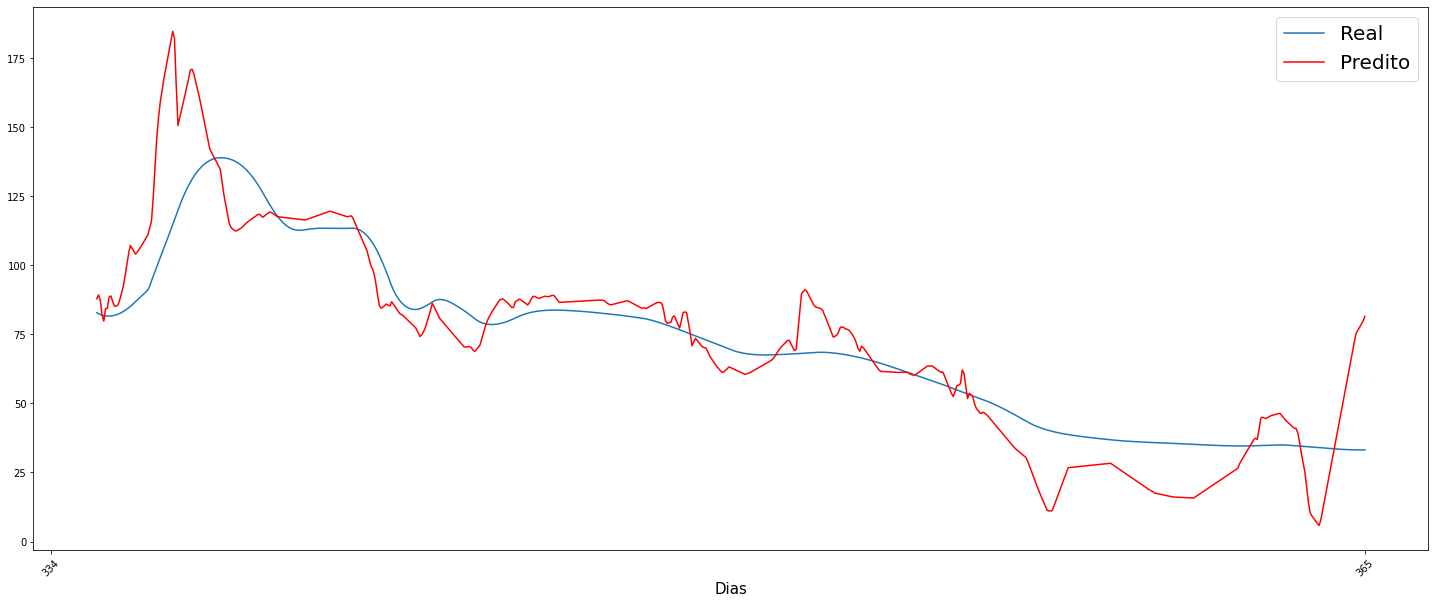

In [12]:
print(df_metricas)
import matplotlib.dates as mdates
# Visualização gráfica das predições comparadas aos valores reais
fig = plt.figure(figsize=(25,10))
ax = fig.add_subplot(1,1,1) 
# plt.title('', fontsize=25)
plt.plot(df_comparacao.index, df_comparacao['Valor_Real'], label = 'Real')
plt.plot(df_comparacao.index, df_comparacao['Valor_Predito'], label = 'Predito', c='r')
plt.legend(fontsize=20)
plt.xlabel('Dias', fontsize=15)
plt.xticks(fontsize=10, rotation=45)

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1)) 
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%M-%d'))

plt.show()

In [13]:
# Saving predictions

df_comparacao.to_csv("1_3-Previsoes_MLP.csv", encoding='utf-8-sig',sep=';',decimal=',')

# Previsão na base de treino

        RSME       MAE      MAPE        R²
0  15.940825  9.937208  0.100945  0.831931


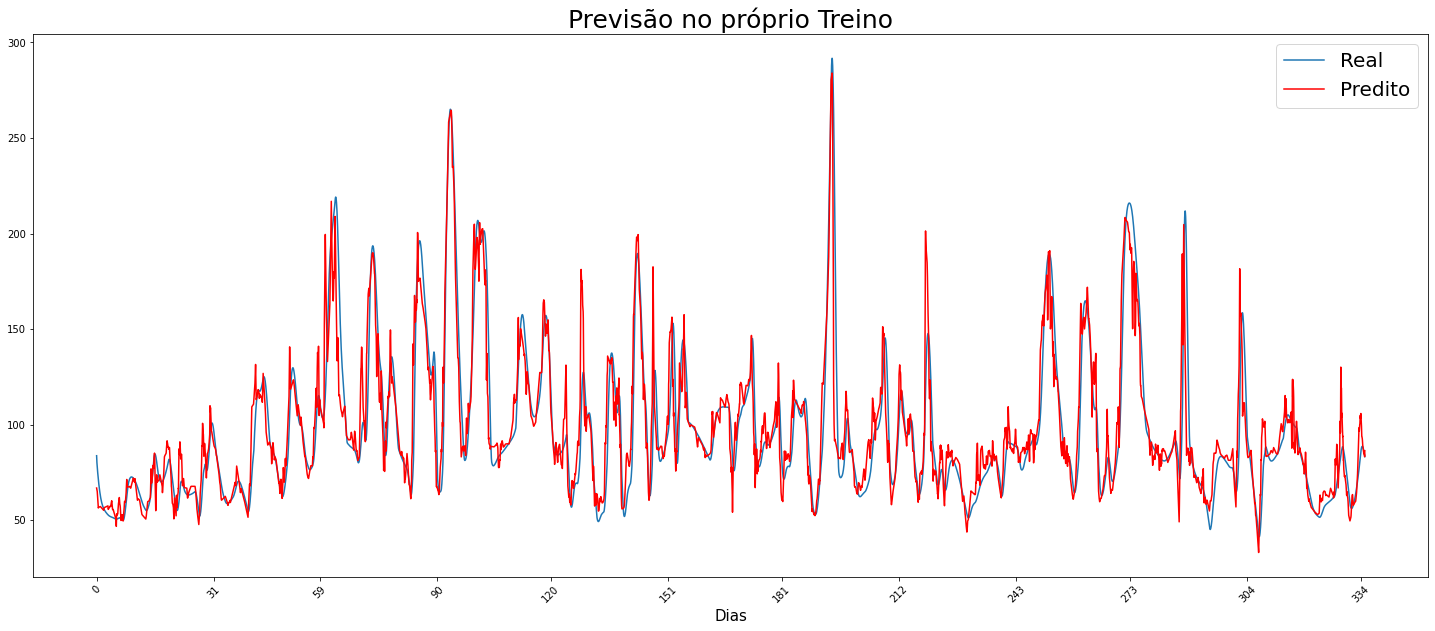

In [14]:
# Realizando a predição no traine
y_train_pred_mlp = mlp_model_cv_gs.predict(normalized_x_train)

# Desnormalização
y_train_pred_mlp = np.array(y_train_pred_mlp).reshape(len(y_train_pred_mlp),1)
y_train_pred_mlp = scalery.inverse_transform(y_train_pred_mlp)
y_train_pred_mlp = pd.DataFrame(y_train_pred_mlp, columns=[normalized_y_train.name], index = normalized_y_train.index)
y_train_pred_mlp = y_train_pred_mlp.squeeze()

y_train_pred_mlp


# Análise dos erros das previsões
rmse_train_mlp = math.sqrt(mean_squared_error(y_train, y_train_pred_mlp))
mae_train_mlp = mean_absolute_error(y_train, y_train_pred_mlp)
mape_train_mlp = mean_absolute_percentage_error(y_train, y_train_pred_mlp)
r2_train_mlp = r2_score(y_train, y_train_pred_mlp)

# Preparação do DataFrame comparativo entre a previsão e o valor real, indexado pelo dia
df_train_comparacao = pd.concat([y_training,y_train_pred_mlp],axis=1)
df_train_comparacao.columns = ['Valor_Real','Valor_Predito']
df_train_comparacao['Diferenca_percentual'] = 100*(df_train_comparacao['Valor_Predito'] - df_train_comparacao['Valor_Real'])/df_train_comparacao['Valor_Real']
df_train_comparacao.sort_index(inplace=True)
df_train_comparacao


df_train_metricas = pd.DataFrame(data={'RSME':[rmse_train_mlp], 'MAE':[mae_train_mlp], 'MAPE':[mape_train_mlp],'R²':[r2_train_mlp]})
print(df_train_metricas)

# Visualização gráfica das predições comparadas aos valores reais
fig = plt.figure(figsize=(25,10))
ax = fig.add_subplot(1,1,1) 
plt.title('Previsão no próprio Treino', fontsize=25)
plt.plot(df_train_comparacao.index, df_train_comparacao['Valor_Real'], label = 'Real')
plt.plot(df_train_comparacao.index, df_train_comparacao['Valor_Predito'], label = 'Predito', c='r')
plt.legend(fontsize=20)
plt.xlabel('Dias', fontsize=15)
plt.xticks(fontsize=10, rotation=45)

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1)) 
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%M-%d'))

plt.show()

In [15]:
# Gráfico de cima, queremos os dados só para o melhor modelo (base de treino)
df_train_comparacao.to_csv('2_3-Previsoes_TREINO_MLP.csv',sep=';',decimal=',',encoding='utf-8-sig')

# FEATURE IMPORTANCE

## PDPs and Permutation Importance

In [16]:
print(normalized_x_train.min())
print(normalized_x_train.max())

Q_entrada     -2.942186
NH_entrada    -2.846533
TSS_entrada   -2.767711
TN_entrada    -2.842474
dtype: float64
Q_entrada      3.060924
NH_entrada     7.473228
TSS_entrada    5.131490
TN_entrada     4.794257
dtype: float64


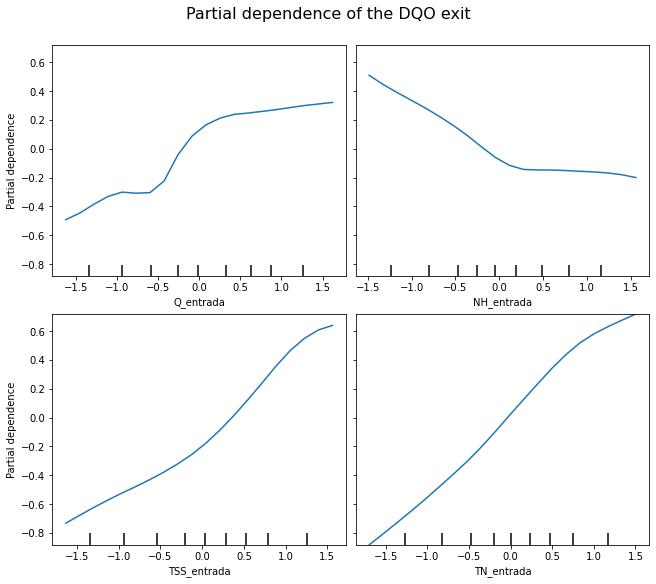

In [17]:
from sklearn.inspection import PartialDependenceDisplay

common_params = {
    "subsample": 50,
    "n_jobs": 2,
    "grid_resolution": 20,
    "random_state": 0,
}

# print("Computing partial dependence plots...")
features_info = {
    # features of interest
    "features": X_training.columns,
    # type of partial dependence plot
    "kind": "average",
    # information regarding categorical features
    # "categorical_features": categorical_features,
}

_, ax = plt.subplots(ncols=2, nrows=2, figsize=(9, 8), constrained_layout=True)
display = PartialDependenceDisplay.from_estimator(
    mlp_model_cv_gs,
    normalized_x_train,
    **features_info,
    ax=ax,
    **common_params,
)

_ = display.figure_.suptitle(
    "Partial dependence of the DQO exit\n",
    fontsize=16,
)

Tree-based models provide an alternative measure of feature importances based on the mean decrease in impurity (MDI). Impurity is quantified by the splitting criterion of the decision trees (Gini, Log Loss or Mean Squared Error). However, this method can give high importance to features that may not be predictive on unseen data when the model is overfitting. Permutation-based feature importance, on the other hand, avoids this issue, since it can be computed on unseen data.Furthermore, impurity-based feature importance for trees are strongly biased and favor high cardinality features (typically numerical features) over low cardinality features such as binary features or categorical variables with a small number of possible categories.
Permutation-based feature importances do not exhibit such a bias. Additionally, the permutation feature importance may be computed performance metric on the model predictions and can be used to analyze any model class (not just tree-based models).

Importance_mean  Importance_std  Importance_mean_normalized
TN_entrada          0.841519        0.013017                    0.295158
TSS_entrada         0.752506        0.013290                    0.263938
NH_entrada          0.730644        0.018919                    0.256270
Q_entrada           0.526405        0.017554                    0.184634

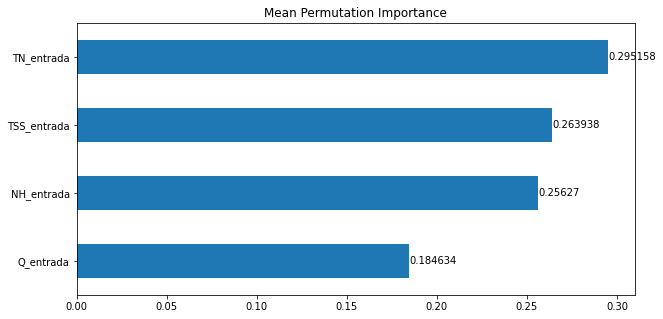

In [18]:
from sklearn.inspection import permutation_importance
r = permutation_importance(mlp_model_cv_gs, normalized_x_train, normalized_y_train,
                           n_repeats=30,
                           random_state=0)
# r.importances_mean
# r.importances_std

df_permutation_importance = pd.DataFrame(
    data={'Importance_mean': r.importances_mean,
          'Importance_std': r.importances_std},
    index=normalized_x_train.columns
)

df_permutation_importance['Importance_mean_normalized'] = df_permutation_importance['Importance_mean']/df_permutation_importance['Importance_mean'].sum()

df_permutation_importance = df_permutation_importance.sort_values('Importance_mean',ascending=False)

ax = df_permutation_importance['Importance_mean_normalized'].sort_values(ascending=True).plot.barh(figsize=(10,5), title='Mean Permutation Importance')
ax.bar_label(ax.containers[0])

df_permutation_importance

In [19]:
df_permutation_importance.to_csv('3_3-Permutation_Importance_MLP.csv',sep=';',decimal=',',encoding='utf-8-sig')

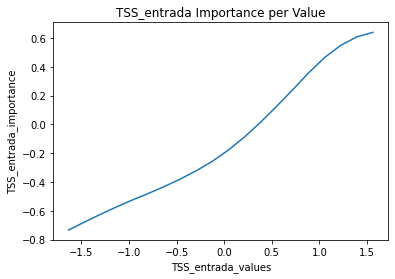

DBO_entrada_importance  Q_entrada_importance  Q_entrada_values  \
0                -0.491195             -0.491195         -1.624177   
1                -0.445522             -0.445522         -1.453397   
2                -0.384574             -0.384574         -1.282618   
3                -0.330776             -0.330776         -1.111839   
4                -0.300393             -0.300393         -0.941059   
5                -0.307913             -0.307913         -0.770280   
6                -0.303884             -0.303884         -0.599501   
7                -0.223557             -0.223557         -0.428721   
8                -0.039612             -0.039612         -0.257942   
9                 0.089054              0.089054         -0.087163   
10                0.167008              0.167008          0.083616   
11                0.213336              0.213336          0.254396   
12                0.239050              0.239050          0.425175   
13                0.248318              0.248318          0.595954   
14                0.259838              0.259838          0.766734   
15                0.271913              0.271913          0.937513   
16                0.286513              0.286513          1.108292   
17                0.300206              0.300206          1.279072   
18                0.311072              0.311072          1.449851   
19                0.321947              0.321947          1.620630   

    NH_entrada_importance  NH_entrada_values  TSS_entrada_importance  \
0                0.510128          -1.484610               -0.732531   
1                0.446153          -1.324545               -0.677003   
2                0.390339          -1.164480               -0.623088   
3                0.336881          -1.004414               -0.571944   
4                0.283217          -0.844349               -0.523482   
5                0.224539          -0.684284               -0.477732   
6                0.162046          -0.524219               -0.429505   
7                0.091777          -0.364154               -0.377451   
8                0.014136          -0.204088               -0.319361   
9               -0.060605          -0.044023               -0.253659   
10              -0.114767           0.116042               -0.175521   
11              -0.143000           0.276107               -0.084658   
12              -0.146727           0.436172                0.017088   
13              -0.147127           0.596238                0.127626   
14              -0.150593           0.756303                0.242362   
15              -0.155680           0.916368                0.360225   
16              -0.160413           1.076433                0.466649   
17              -0.167280           1.236498                0.550035   
18              -0.179851           1.396563                0.608392   
19              -0.199331           1.556629                0.639771   

    TSS_entrada_values  
0            -1.634561  
1            -1.466265  
2            -1.297970  
3            -1.129674  
4            -0.961378  
5            -0.793082  
6            -0.624787  
7            -0.456491  
8            -0.288195  
9            -0.119899  
10            0.048396  
11            0.216692  
12            0.384988  
13            0.553284  
14            0.721579  
15            0.889875  
16            1.058171  
17            1.226467  
18            1.394762  
19            1.563058

In [20]:
dict_data = {}
df_pdp = pd.DataFrame(display.pd_results[0]['average'].flatten(),columns=['DBO_entrada_importance'])
for i in range(len(display.pd_results)):
    if i!=3 and i!=8: # para o NO, que não tem FI, não temos os 20 dados para plotar
        dict_data[f"{X.columns[i]}_importance"] = display.pd_results[i]['average']
        dict_data[f"{X.columns[i]}_values"]  = display.pd_results[i]['values']
        # df_pdp[f"{X.columns[i]}_importance"] = dict_data[f"{X.columns[i]}_importance"].flatten()
        df_pdp[f"{X.columns[i]}_importance"] = display.pd_results[i]['average'][0]
        df_pdp[f"{X.columns[i]}_values"] = display.pd_results[i]['values'][0]


plt.plot(df_pdp.loc[:, 'TSS_entrada_values'], df_pdp.loc[:, 'TSS_entrada_importance'])
plt.xlabel('TSS_entrada_values')
plt.ylabel('TSS_entrada_importance')
plt.title('TSS_entrada Importance per Value')
plt.show()


df_pdp.to_csv('4_3-PDPs_MLP.csv',encoding='utf-8-sig',decimal=',',sep=';')
df_pdp

In [21]:
# Avaliando na base de TESTE o impacto nas métricas causado pela permutação de valores de cada uma das variáveis.
# https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance
scoring = ['r2', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error']
r_multi = permutation_importance(
    mlp_model_cv_gs, normalized_x_test, normalized_y_test, n_repeats=30, random_state=0, scoring=scoring)

# Apenas mostrar as variáveis cujas importâncias são maiores que 2 vezes o respectivo desvio padrão (para todas as métricas)
for metric in r_multi:
    print(f"{metric}")
    r1 = r_multi[metric]
    for i in r1.importances_mean.argsort()[::-1]:
        if r1.importances_mean[i] - 2 * r1.importances_std[i] > 0:
            print(f"    {X.columns[i]}: "
                  f"{r1.importances_mean[i]:.3f}"
                  f" +/- {r1.importances_std[i]:.3f}\n")

r2
    TN_entrada: 1.780 +/- 0.098

    TSS_entrada: 0.680 +/- 0.040

    NH_entrada: 0.463 +/- 0.034

neg_mean_absolute_percentage_error
    TN_entrada: 0.791 +/- 0.097

    TSS_entrada: 0.713 +/- 0.107

    NH_entrada: 0.515 +/- 0.098

neg_mean_squared_error
    TN_entrada: 1.033 +/- 0.057

    TSS_entrada: 0.395 +/- 0.023

    NH_entrada: 0.269 +/- 0.020



In [22]:
# Avaliando na base de TREINO o impacto nas métricas causado pela permutação de valores de cada uma das variáveis.
# https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance
scoring = ['r2', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error'] #, 'neg_mean_absolute_error'
r_multi = permutation_importance(
    mlp_model_cv_gs, normalized_x_train, normalized_y_train, n_repeats=30, random_state=0, scoring=scoring)

# Apenas mostrar as variáveis cujas importâncias são maiores que 2 vezes o respectivo desvio padrão (para todas as métricas)
for metric in r_multi:
    print(f"{metric}")
    r1 = r_multi[metric]
    for i in r1.importances_mean.argsort()[::-1]:
        if r1.importances_mean[i] - 2 * r1.importances_std[i] > 0:
            print(f"    {X.columns[i]}: "
                  f"{r1.importances_mean[i]:.3f}"
                  f" +/- {r1.importances_std[i]:.3f}")

r2
    TN_entrada: 0.842 +/- 0.013
    TSS_entrada: 0.753 +/- 0.013
    NH_entrada: 0.731 +/- 0.019
    Q_entrada: 0.526 +/- 0.018
neg_mean_absolute_percentage_error
    TN_entrada: 2.439 +/- 0.643
    NH_entrada: 1.839 +/- 0.281
    Q_entrada: 1.517 +/- 0.335
    TSS_entrada: 1.147 +/- 0.115
neg_mean_squared_error
    TN_entrada: 0.842 +/- 0.013
    TSS_entrada: 0.753 +/- 0.013
    NH_entrada: 0.731 +/- 0.019
    Q_entrada: 0.526 +/- 0.018


## LIME - Local Interpretable Model-Agnostic Explanations 

In [23]:
import lime
import lime.lime_tabular

# LIME has one explainer for all the models
explainer = lime.lime_tabular.LimeTabularExplainer(normalized_x_train.values, feature_names=X.columns.values.tolist(),
                                                  class_names=[y.name], verbose=True, mode='regression')

### Cálculo da importância de cada variável para um registro específico

In [24]:
# normalized_x_test.iloc[5]
# normalized_x_test.values[5]

# Choose the 5th instance and use it to predict the results
j = 5
exp = explainer.explain_instance(normalized_x_test.iloc[j], mlp_model_cv_gs.predict, num_features=4)

# Show the predictions
exp.show_in_notebook(show_table=True)

exp.as_list()

Intercept 0.32909921781213824
Prediction_local [-1.04161024]
Right: -0.33433386304558027


c:\Users\hydro\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(


[('Q_entrada <= -0.76', -0.6184545939832177),
 ('-0.05 < NH_entrada <= 0.64', -0.32880877651066986),
 ('-0.74 < TSS_entrada <= 0.04', -0.24137406344717158),
 ('-0.65 < TN_entrada <= 0.01', -0.18207202824838306)]

Interpretação: O valor Predito é o central da primeira imagem (Predicted value).
As variáveis à esquerda, tiveram influência negativa para o valor predito, enquanto que as variáveis à direita tiveram influência positiva.
Lista de Features com os respectivos valores alimentados para a previsão.

In [25]:
# Choose the 10th instance and use it to predict the results
j = 10
exp = explainer.explain_instance(normalized_x_test.iloc[j], mlp_model_cv_gs.predict, num_features=6)

# Show the predictions
exp.show_in_notebook(show_table=True)

exp.as_list()

Intercept 0.024284779678138513
Prediction_local [-0.12222193]
Right: -0.3110991124872741


c:\Users\hydro\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(


[('-0.05 < NH_entrada <= 0.64', -0.30619758140323217),
 ('-0.76 < Q_entrada <= -0.02', -0.25722093872293034),
 ('0.01 < TN_entrada <= 0.58', 0.23057841505713286),
 ('0.04 < TSS_entrada <= 0.64', 0.18633339926993397)]

In [26]:
# Choose the LAST instance and use it to predict the results
j = -1
exp = explainer.explain_instance(normalized_x_test.iloc[j], mlp_model_cv_gs.predict, num_features=6)

# Show the predictions
exp.show_in_notebook(show_table=True)

exp.as_list()

Intercept 0.3431517848806467
Prediction_local [-1.21129356]
Right: -0.4060447437406947


c:\Users\hydro\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(


[('TN_entrada <= -0.65', -0.8556652957652583),
 ('Q_entrada <= -0.76', -0.6536854363056449),
 ('TSS_entrada <= -0.74', -0.6114454004004967),
 ('NH_entrada <= -0.64', 0.566350785383924)]

In [27]:
# Apply lime to last 20 observations
from interpret.blackbox import LimeTabular
from interpret import show


# Initilize Lime for Tabular data
lime = LimeTabular(model=mlp_model_cv_gs, 
                   data=normalized_x_train, 
                   random_state=1)
# Get local explanations
lime_local = lime.explain_local(normalized_x_test, 
                                normalized_y_test, 
                                name='LIME')

show(lime_local)

KeyboardInterrupt: 

### Análise de Feature Importance geral com LIME ao invés de apenas para ocorrência específica

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import re
l=[]
for n in range(0,normalized_x_test.shape[0]):
     exp = explainer.explain_instance(normalized_x_test.values[n], mlp_model_cv_gs.predict, num_features=X.shape[1])
     a=exp.as_list()
     l.append(a)


df_lime_importances = pd.DataFrame()
for sublist in l:
    row_values = {}
    for condition, value in sublist:
        match = re.search(r'([a-zA-Z_]+)', condition)
        if match:
            text = match.group(1)        
            row_values[text] = value
    df_lime_importances = df_lime_importances.append(row_values, ignore_index=True)

df_lime_importances

Intercept -0.024840492830567523
Prediction_local [-0.56406296]
Right: -0.4673693842448565
Intercept -0.05758552506516776
Prediction_local [-0.54753605]
Right: -0.41376651636371
Intercept -0.06449034254167602
Prediction_local [-0.51728848]
Right: -0.3690898176210665
Intercept -0.016350100919564514
Prediction_local [-0.60836775]
Right: -0.3337782259754365
Intercept -0.049248648657188754
Prediction_local [-0.53829402]
Right: -0.3160950670511265
Intercept -0.0003692104562350307
Prediction_local [-0.64537132]
Right: -0.3163593002406265
Intercept -0.04280804540121727
Prediction_local [-0.53153494]
Right: -0.32230080056826166
Intercept -0.07189979017031871
Prediction_local [-0.37506311]
Right: -0.33544199164495075
Intercept -0.0767780117849803
Prediction_local [-0.45710377]
Right: -0.33890882450405857
Intercept -0.040822136158422895
Prediction_local [-0.46003463]
Right: -0.323130291060871
Intercept -0.1544896426808119
Prediction_local [-0.14154902]
Right: -0.3073517576176838
Intercept -0.1686

Q_entrada  TSS_entrada  NH_entrada  TN_entrada
0    -0.431517    -0.291788    0.107198    0.076885
1    -0.379912    -0.249714    0.064138    0.075539
2    -0.378713    -0.258679    0.125451    0.059143
3    -0.419758    -0.272770    0.097064    0.003447
4    -0.423521    -0.274714    0.150278    0.058911
..         ...          ...         ...         ...
714  -0.397956    -0.948958   -0.072791   -0.207964
715  -0.400930    -0.936913    0.007049   -0.171343
716  -0.424480    -0.938594   -0.062681   -0.185588
717  -0.428177    -0.964639   -0.039372   -0.151313
718  -0.432875    -0.973576   -0.060546   -0.125552

[719 rows x 4 columns]

In [ ]:
df_lime_absolute_importances = df_lime_importances.copy()

for i in range(df_lime_importances.shape[1]):
    df_lime_absolute_importances.iloc[:,i] = df_lime_absolute_importances.iloc[:,i].apply(lambda x: abs(float(x)))
     
df_lime_absolute_importances.head()

Q_entrada  TSS_entrada  NH_entrada  TN_entrada
0   0.431517     0.291788    0.107198    0.076885
1   0.379912     0.249714    0.064138    0.075539
2   0.378713     0.258679    0.125451    0.059143
3   0.419758     0.272770    0.097064    0.003447
4   0.423521     0.274714    0.150278    0.058911

In [ ]:
df_lime_absolute_importances.mean()/df_lime_absolute_importances.mean().sum()

Q_entrada      0.273582
TSS_entrada    0.571686
NH_entrada     0.067918
TN_entrada     0.086814
dtype: float64

<Axes: >

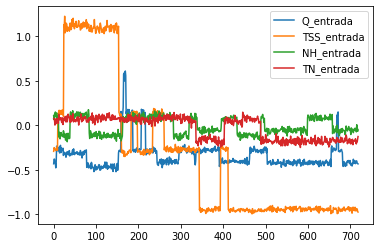

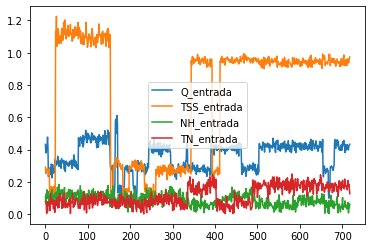

In [ ]:
# df_lime_importances['TN'].plot()
df_lime_importances.plot()
df_lime_absolute_importances.plot()

### Análise de Feature Importance geral com LIME ao invés de apenas para ocorrência específica para a BASE DE TREINO

In [ ]:
l=[]
for n in range(0,normalized_x_train.shape[0]):
     exp = explainer.explain_instance(normalized_x_train.values[n], mlp_model_cv_gs.predict, num_features=X.shape[1])
     a=exp.as_list()
     l.append(a)


df_lime_train_importances = pd.DataFrame()
for sublist in l:
    row_values = {}
    for condition, value in sublist:
        match = re.search(r'([a-zA-Z_]+)', condition)
        if match:
            text = match.group(1)        
            row_values[text] = value
    df_lime_train_importances = df_lime_train_importances.append(row_values, ignore_index=True)

df_lime_train_importances

Intercept 0.22513411622929533
Prediction_local [-1.33996481]
Right: -0.7814265809937863
Intercept 0.1700421789466634
Prediction_local [-1.21940449]
Right: -0.7713920951618717
Intercept 0.1703340529453486
Prediction_local [-1.23854691]
Right: -0.761357609329957
Intercept 0.17117889808265854
Prediction_local [-1.2080108]
Right: -0.7513231234980422
Intercept 0.2432396290059259
Prediction_local [-1.31922577]
Right: -0.7421415749691237
Intercept 0.1905981536562786
Prediction_local [-1.24102807]
Right: -0.7431142637376652
Intercept 0.2176838361252023
Prediction_local [-1.27322073]
Right: -0.7475170698611748
Intercept 0.22058672739087273
Prediction_local [-1.23930485]
Right: -0.757827660127935
Intercept 0.20653959151348697
Prediction_local [-1.2542827]
Right: -0.768138250394695
Intercept 0.20774445467407623
Prediction_local [-1.23869746]
Right: -0.778448840661456
Intercept 0.1955699175399007
Prediction_local [-1.21566542]
Right: -0.788759430928217
Intercept 0.21899570274956645
Prediction_loca

TSS_entrada  Q_entrada  TN_entrada  NH_entrada
0       -0.940844  -0.388065   -0.177296   -0.058894
1       -0.905300  -0.384106   -0.170898    0.070857
2       -0.932418  -0.397338   -0.195358    0.116234
3       -0.923777  -0.421232   -0.154541    0.120360
4       -0.979383  -0.464985   -0.181817    0.063721
...           ...        ...         ...         ...
8037    -0.302543  -0.444581    0.038799    0.111086
8038    -0.290267  -0.439348    0.069249    0.047174
8039    -0.311793  -0.426169    0.069353    0.076016
8040    -0.271294  -0.411381    0.018754    0.094124
8041    -0.261889  -0.381082    0.010678    0.102016

[8042 rows x 4 columns]

In [ ]:
df_lime_train_absolute_importances = df_lime_train_importances.copy()

for i in range(df_lime_importances.shape[1]):
    df_lime_train_absolute_importances.iloc[:,i] = df_lime_train_absolute_importances.iloc[:,i].apply(lambda x: abs(float(x)))
     
df_lime_train_absolute_importances

TSS_entrada  Q_entrada  TN_entrada  NH_entrada
0        0.940844   0.388065    0.177296    0.058894
1        0.905300   0.384106    0.170898    0.070857
2        0.932418   0.397338    0.195358    0.116234
3        0.923777   0.421232    0.154541    0.120360
4        0.979383   0.464985    0.181817    0.063721
...           ...        ...         ...         ...
8037     0.302543   0.444581    0.038799    0.111086
8038     0.290267   0.439348    0.069249    0.047174
8039     0.311793   0.426169    0.069353    0.076016
8040     0.271294   0.411381    0.018754    0.094124
8041     0.261889   0.381082    0.010678    0.102016

[8042 rows x 4 columns]

In [ ]:
df_lime_train_absolute_importances.mean()/df_lime_train_absolute_importances.mean().sum()

TSS_entrada    0.542327
Q_entrada      0.305771
TN_entrada     0.074587
NH_entrada     0.077315
dtype: float64

<Axes: >

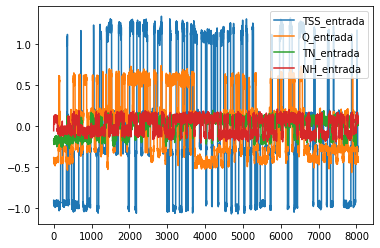

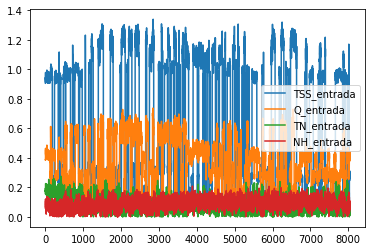

In [ ]:
# df_lime_train_importances['TN'].plot()
df_lime_train_importances.plot()
df_lime_train_absolute_importances.plot()